<a href="https://colab.research.google.com/github/sudipta-on/Quantum-Many-Body-Problem-using-Netket/blob/main/J1_J2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\textbf{Ground-State: J1-J2 model}$$

$\qquad \qquad \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \text{ - Sudipta Majumder}$

$7 $ $\text{July},2024$


We will use NetKet to obtain the ground state of the J1-J2 model in one-dimension with periodic boundary conditions, using a Neural Network variational wave-function. The Hamiltonian of the model is given by:

$$ H = \sum_{i=1}^{L} J_{1}\vec{\sigma}_{i} \cdot \vec{\sigma}_{i+1} + J_{2} \vec{\sigma}_{i} \cdot \vec{\sigma}_{i+2} $$

where the sum is over sites of the 1-D chain. Here $\vec{\sigma}=(\sigma^x,\sigma^y,\sigma^z)$ is the vector of Pauli matrices.

We will also explore some useful functionalities provided by the package.

## Objectives:
    1. Defining custom Hamiltonians
    2. Defining the variational ansatz
    3. Variational Monte Carlo Optimisation
    4. Measuring observables
    5. Data Visualisation
    6. Sanity Check: Exact Diagonalisation
    
Let's start.

## Installing and importing Netket

In [1]:
!pip install --quiet netket

In [2]:
# ensure we run on the CPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time

%matplotlib inline
matplotlib.rc('font', family = 'Serif', size = 14)
matplotlib.rc('xtick', labelsize = 10)
matplotlib.rc('ytick', labelsize = 10)
matplotlib.rcParams['figure.figsize'] = (10,6)

## 1. Defining a Custom Hamiltonian

The first thing to do is to define the graph (lattice) on which to specify the Hamiltonian. Here we would like to build a one-dimensional graph with both nearest and next nearest neighbour bonds. The graph is created in the ``nk.graph.CustomGraph`` class. To initialise the class we simply provide a list of edges in the ``[[site_i, site_j, edge_color], ...]``

In [3]:
#Couplings J1 and J2
J = [1, 0.2]
L = 14

In [4]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])

# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

In [5]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

In [6]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [7]:
# Custom Hamiltonian operator
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

## 2. Defining the Machine or Model

For this tutorial, we shall use the most common type of neural network: fully connected feedforward neural network ``nk.machine.FFNN``. Other types of neural networks available will be discussed in other tutorials.

In [8]:
import netket.nn as nknn
import flax.linen as nn

import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1],
                     use_bias=True,
                     param_dtype=np.complex128,
                     kernel_init=nn.initializers.normal(stddev=0.01),
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

## 3. Variational Monte Carlo Optimisation

We have now set up our model (Hamiltonian, Graph, Hilbert Space) and can proceed to optimise the variational ansatz we chose, namely the ``ffnn`` machine.

To setup the variational Monte Carlo optimisation tool, we have to provide a sampler ``nk.sampler`` and an optimizer ``nk.optimizer``.

In [9]:
model = FFNN()

# We shall use an exchange Sampler which preserves the global magnetization (as this is a conserved quantity in the model)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)

# Construct the variational state
vs = nk.vqs.MCState(sa, model, n_samples=1008)

# We choose a basic, albeit important, Optimizer: the Stochastic Gradient Descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.01, holomorphic = True)
start  = time.time()
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)
end = time.time()

ffn_time = end-start

print('### Feed Forward calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward calculation took',ffn_time,'seconds')

### Feed Forward calculation
Has 420 parameters
The Feed Forward calculation took 0.0005984306335449219 seconds


## 4. Measuring Observables

Before running the optimization, it can be helpful to add some observables to keep track off during the optimization. For our purpose, let us measure the antiferromagnetic structure factor, defined as:

$$ \frac{1}{L} \sum_{ij} \langle \hat{\sigma}_{i}^z \cdot \hat{\sigma}_{j}^z\rangle e^{i\pi(i-j)}$$

In [10]:
# We need to specify the local operators as a matrix acting on a local Hilbert space
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L


In [11]:
# Run the optimization protocol
gs.run(out='test', n_iter=600, obs={'Structure Factor': structure_factor})

  0%|          | 0/600 [00:00<?, ?it/s]

(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.8044445514678955
   	Params: 0.5024008750915527,)

## 5. Data Visualisation

Now that we have optimized our machine to find the ground state of the $J_1-J_2$ model, let's look at what we have.
The relevant data are stored in the ".log" file while the optimized parameters are in the ".wf" file. The files are all in json format.

We shall extract the energy as well as specified observables (antiferromagnetic structure factor in our case) from the ".log" file.

In [12]:
# Load the data from the .log file
import json

data=json.load(open("test.log"))

iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

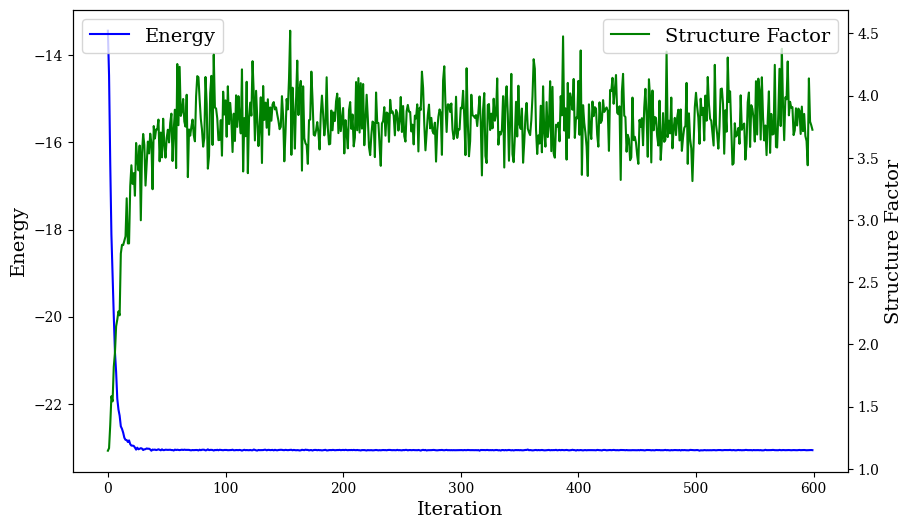

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx()
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [14]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 3.839(0.030)
Energy = -23.063(0.000)


## 6. Sanity Check: Exact Diagonalisation

Now that we have obtained some results using VMC, it is a good time to check the quality of our results (at least for small system sizes). For this purpose, Netket provides exact diagonalisation tools.

In [15]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]

In [16]:
print("Exact Ground-state Structure Factor: {0:.3f}".format(structure_factor_gs))
print("Exact ground state energy = {0:.3f}".format(E_gs[0]))

Exact Ground-state Structure Factor: 3.803
Exact ground state energy = -23.064
